In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
number_of_rows = 4000

In [3]:
!pip install spacy networkx matplotlib wordcloud community nltk
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 65.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Task 1: Named Entity Recognition & Graph Construction

In [4]:
# Step 1: Setup
import pandas as pd
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

In [5]:
# Step 2: Load Dataset
df = pd.read_csv("/kaggle/input/nytppopular-csv/nytpopular.csv")  # Replace with your actual file path
df.dropna(subset=["bag_of_phrases"], inplace=True)


In [6]:
df.info()
len(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9100 entries, 0 to 9099
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              9100 non-null   int64 
 1   retweet_count   9100 non-null   int64 
 2   reply_count     9100 non-null   int64 
 3   like_count      9100 non-null   int64 
 4   url             9100 non-null   object
 5   date            9100 non-null   object
 6   bag_of_phrases  9100 non-null   object
dtypes: int64(4), object(3)
memory usage: 497.8+ KB


9100

In [7]:
df = df.sample(n=number_of_rows, random_state=42)  # random_state ensures reproducibility


In [8]:
# Step 3: Named Entity Extraction
entities_dict = defaultdict(set)
person_counts, org_counts, loc_counts = Counter(), Counter(), Counter()

for idx, row in df.iterrows():
    doc = nlp(row['bag_of_phrases'])
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            entities_dict[row['id']].add(ent.text)
            person_counts[ent.text] += 1
        elif ent.label_ == "ORG":
            entities_dict[row['id']].add(ent.text)
            org_counts[ent.text] += 1
        elif ent.label_ == "GPE":
            entities_dict[row['id']].add(ent.text)
            loc_counts[ent.text] += 1


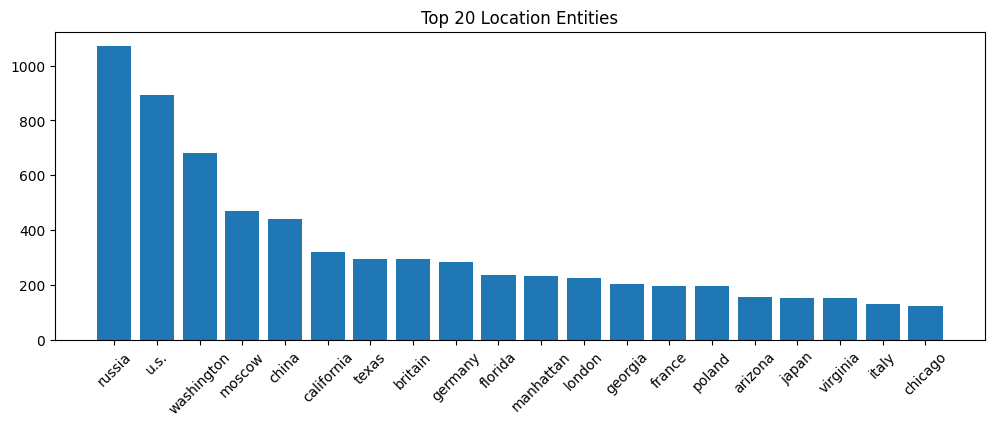

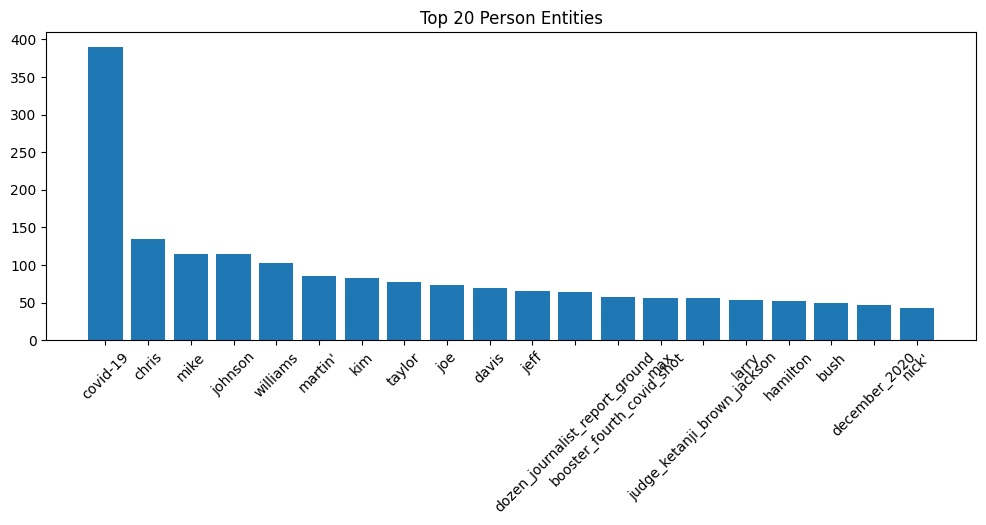

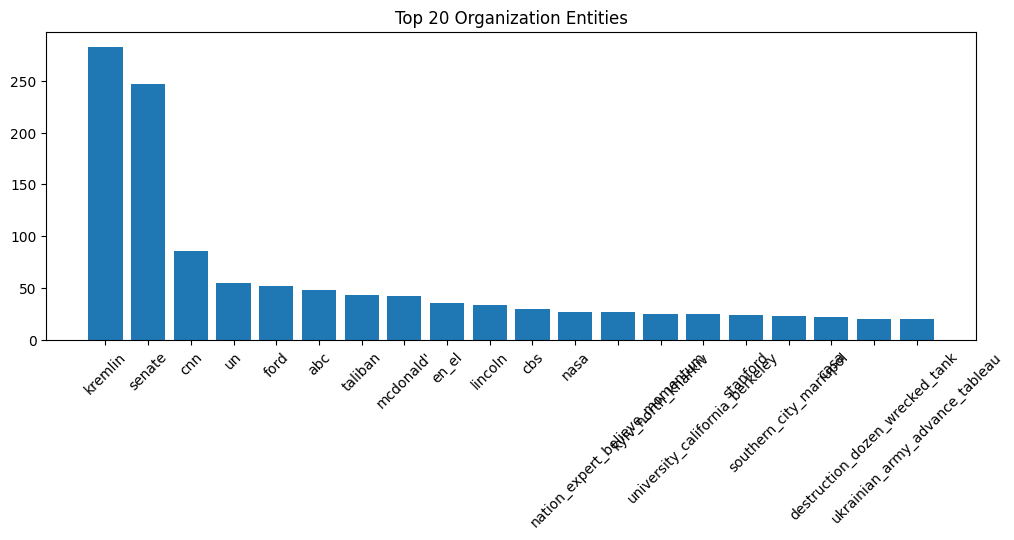

In [9]:
# Step 4: Plot Entity Histograms
def plot_entity_histogram(counter, title):
    top = counter.most_common(20)
    labels, values = zip(*top)
    plt.figure(figsize=(12, 4))
    plt.bar(labels, values)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_entity_histogram(loc_counts, "Top 20 Location Entities")
plot_entity_histogram(person_counts, "Top 20 Person Entities")
plot_entity_histogram(org_counts, "Top 20 Organization Entities")


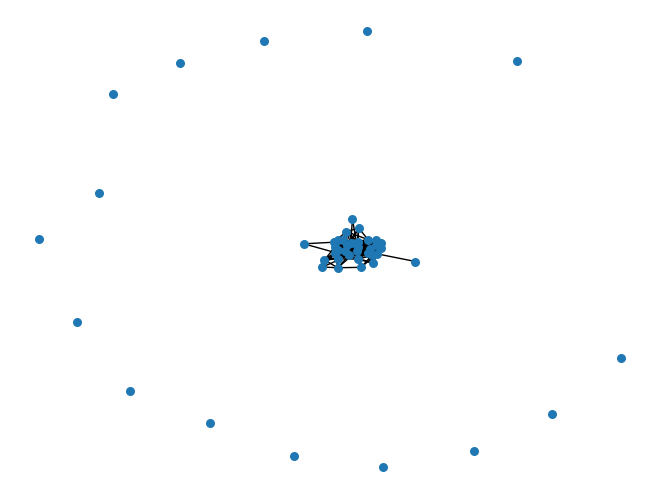

In [10]:
# Step 5: Construct Graph
G = nx.Graph()
for i in range(len(df)):
    G.add_node(df.iloc[i]['id'])

ids = df['id'].tolist()
for i in range(len(ids)):
    for j in range(i + 1, len(ids)):
        if entities_dict[ids[i]] & entities_dict[ids[j]]:
            G.add_edge(ids[i], ids[j])

# Draw the graph (small sample if too large)
sample_graph = G.subgraph(list(G.nodes)[:50])
nx.draw(sample_graph, with_labels=False, node_size=30)
plt.show()


In [11]:
print("Task 1 completed")

Task 1 completed


## Task 2: Degree Distribution & Centrality Stats

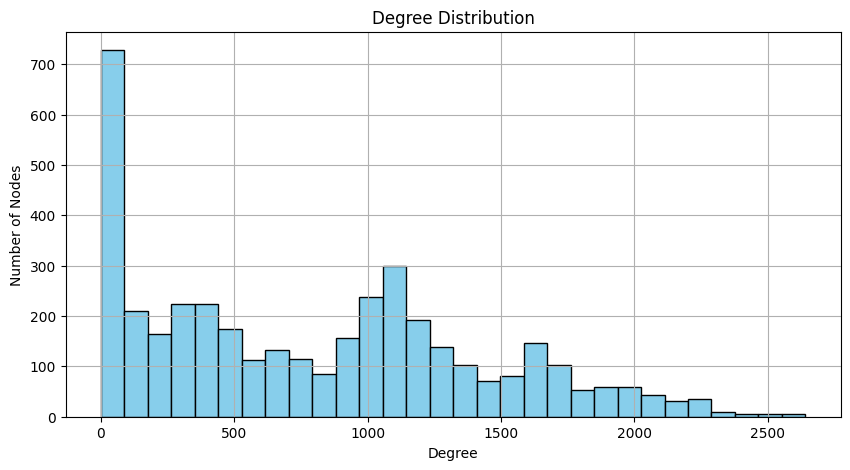

In [12]:
# Step 1: Compute Degree Centrality
import numpy as np

degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, "degree")

# Plot degree distribution
degrees = list(degree_dict.values())
plt.figure(figsize=(10, 5))
plt.hist(degrees, bins=30, color='skyblue', edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()

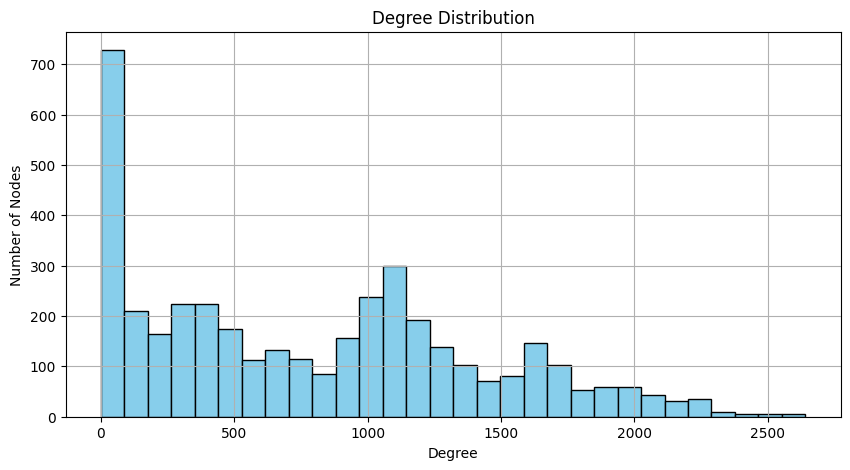

In [13]:
# Step 1: Compute Degree Centrality
import numpy as np

degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, "degree")

# Plot degree distribution
degrees = list(degree_dict.values())
plt.figure(figsize=(10, 5))
plt.hist(degrees, bins=30, color='skyblue', edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()

In [14]:
# Step 2: Centrality Statistics Table
degree_centrality = nx.degree_centrality(G)

max_deg_centrality = max(degree_centrality.values())
min_deg_centrality = min(degree_centrality.values())
avg_deg_centrality = np.mean(list(degree_centrality.values()))

try:
    avg_path_length = nx.average_shortest_path_length(G)
except:
    # In case the graph is not fully connected
    largest_cc = max(nx.connected_components(G), key=len)
    avg_path_length = nx.average_shortest_path_length(G.subgraph(largest_cc))

summary_df = pd.DataFrame({
    "Metric": ["Max Degree Centrali y", "Min Degree Centrality", "Average Degree Centrality", "Average Path Length"],
    "Value": [max_deg_centrality, min_deg_centrality, avg_deg_centrality, avg_path_length]
})

print(summary_df)


                      Metric     Value
0      Max Degree Centrali y  0.660665
1      Min Degree Centrality  0.000000
2  Average Degree Centrality  0.197166
3        Average Path Length  1.775518


In [15]:
print("Task 2 completed")

Task 2 completed


## Task 3: Betweenness & Closeness Centrality Analysis

In [16]:
# Step 1: Compute Centrality Measures
from tqdm import tqdm

betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)

# Add attributes to the graph
nx.set_node_attributes(G, betweenness, "betweenness")
nx.set_node_attributes(G, closeness, "closeness")


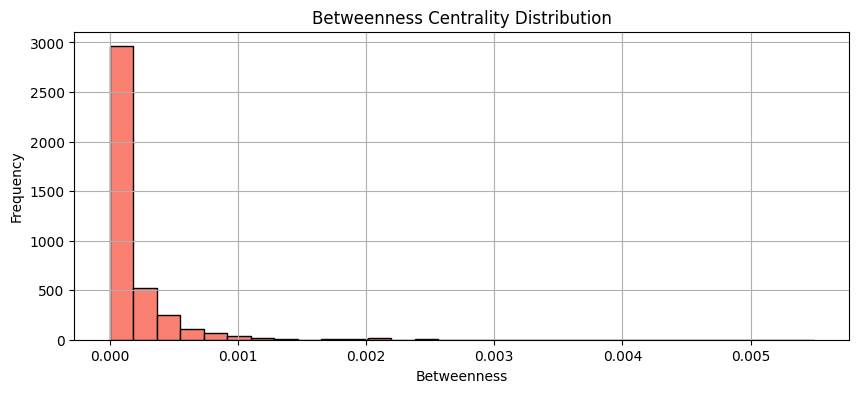

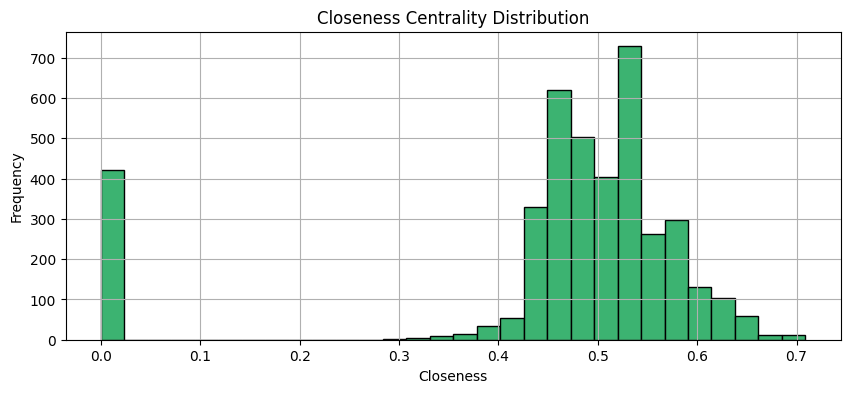

In [17]:
# Step 2: Plot Centrality Distributions
plt.figure(figsize=(10, 4))
plt.hist(list(betweenness.values()), bins=30, color='salmon', edgecolor='black')
plt.title("Betweenness Centrality Distribution")
plt.xlabel("Betweenness")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(list(closeness.values()), bins=30, color='mediumseagreen', edgecolor='black')
plt.title("Closeness Centrality Distribution")
plt.xlabel("Closeness")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [18]:
# Step 3: Save Centrality Scores
centrality_df = pd.DataFrame({
    'id': list(G.nodes()),
    'betweenness': [betweenness[n] for n in G.nodes()],
    'closeness': [closeness[n] for n in G.nodes()],
})

centrality_df.to_csv("centrality_scores.csv", index=False)


In [19]:
# Step 4: Comment on Top Central Nodes' Content
top_betweenness = centrality_df.sort_values(by='betweenness', ascending=False).head(5)
top_closeness = centrality_df.sort_values(by='closeness', ascending=False).head(5)

print("Top 5 Betweenness Nodes:")
print(top_betweenness)

print("\nTop 5 Closeness Nodes:")
print(top_closeness)

print("\nBag of Phrases of Top Betweenness Nodes:")
for node_id in top_betweenness['id']:
    print(f"\nID: {node_id}\nText: {df[df['id'] == node_id]['bag_of_phrases'].values[0]}")

print("\nBag of Phrases of Top Closeness Nodes:")
for node_id in top_closeness['id']:
    print(f"\nID: {node_id}\nText: {df[df['id'] == node_id]['bag_of_phrases'].values[0]}")


Top 5 Betweenness Nodes:
                       id  betweenness  closeness
1301  1503095321550807044     0.005496   0.694192
2066  1480903605758709770     0.003089   0.662155
1052  1513607223255216138     0.002491   0.686300
3123  1513607224798625800     0.002491   0.686300
1107  1513607240263127040     0.002491   0.686300

Top 5 Closeness Nodes:
                       id  betweenness  closeness
3105  1489623577397800968     0.002155   0.708959
764   1489984706611396615     0.002155   0.708959
1176  1489622486337699848     0.002155   0.708959
2342  1489624805485821952     0.002155   0.708959
664   1489622030303604739     0.002155   0.708959

Bag of Phrases of Top Betweenness Nodes:

ID: 1503095321550807044
Text: [' ', '  ', '#', '$', '+', '-', '._1', '/', '/_illustration', '/_photographs', '03', '1', '1.5_billion', '10', '100', '100.read', '10_12', '10_day', '10_minute', '11', '12', '13', '130,000', '1492', '15th', '16', '16_year_old', '17', '17_year_old', '19', '1945', '1956', '1962',

In [20]:
print("Task 3 completed")

Task 3 completed


## Task 4: Clustering Coefficient Analysis

In [21]:
# Step 1: Compute Clustering Coefficient
clustering = nx.clustering(G)
nx.set_node_attributes(G, clustering, "clustering")

# Add clustering to existing centrality DataFrame
centrality_df["clustering"] = centrality_df["id"].map(clustering)

# Save the updated DataFrame
centrality_df.to_csv("centrality_with_clustering.csv", index=False)


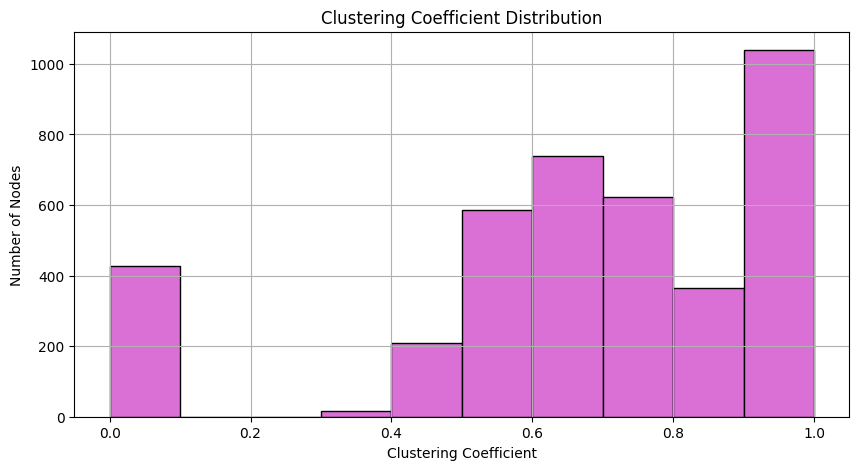

In [22]:
# Step 2: Plot Histogram of Clustering Coefficients
plt.figure(figsize=(10, 5))
plt.hist(list(clustering.values()), bins=10, color='orchid', edgecolor='black')
plt.title("Clustering Coefficient Distribution")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()


In [23]:
print("Task 4 completed")

Task 4 completed


## Task 5: Most Frequent Tokens and Named Entities vs Retweet/Like/Reply Counts

In [24]:
# Step 1: Preprocess and extract named entities & tokens

from collections import Counter
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_named_entities(text):
    doc = nlp(text)
    persons = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    orgs = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    locs = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
    return persons, orgs, locs

def get_token_list(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]


In [25]:
# Step 2: Apply NER & tokenization

# Apply and store token and entity data
token_lists = []
person_entities = []
org_entities = []
loc_entities = []

for text in tqdm(df['bag_of_phrases']):
    tokens = get_token_list(text)
    persons, orgs, locs = extract_named_entities(text)

    token_lists.append(tokens)
    person_entities.append(persons)
    org_entities.append(orgs)
    loc_entities.append(locs)

df['tokens'] = token_lists
df['person_entities'] = person_entities
df['org_entities'] = org_entities
df['loc_entities'] = loc_entities

100%|██████████| 4000/4000 [25:03<00:00,  2.66it/s]


In [26]:
# Step 3: Helper function to get frequent tokens/entities

def top_items_by_metric(df, metric, top_n=5):
    sorted_df = df.sort_values(by=metric, ascending=False)
    bottom_df = df.sort_values(by=metric, ascending=True)

    def aggregate_freq(data, key):
        items = sum(data[key].tolist(), [])
        return Counter(items).most_common(10)

    top_tokens = aggregate_freq(sorted_df.head(top_n), 'tokens')
    top_ents = aggregate_freq(sorted_df.head(top_n), 'person_entities') + \
               aggregate_freq(sorted_df.head(top_n), 'org_entities') + \
               aggregate_freq(sorted_df.head(top_n), 'loc_entities')

    bottom_tokens = aggregate_freq(bottom_df.head(top_n), 'tokens')
    bottom_ents = aggregate_freq(bottom_df.head(top_n), 'person_entities') + \
                  aggregate_freq(bottom_df.head(top_n), 'org_entities') + \
                  aggregate_freq(bottom_df.head(top_n), 'loc_entities')

    return {
        'top_tokens': top_tokens,
        'top_entities': top_ents,
        'bottom_tokens': bottom_tokens,
        'bottom_entities': bottom_ents
    }

In [27]:
# Step 4: Analyze and save results

metrics = ['retweet_count', 'reply_count', 'like_count']
results = {}

for metric in metrics:
    print(f"Analyzing: {metric}")
    results[metric] = top_items_by_metric(df, metric)

# Optionally save to file
import json
with open("token_entity_popularity_analysis.json", "w") as f:
    json.dump(results, f, indent=2)

Analyzing: retweet_count
Analyzing: reply_count
Analyzing: like_count


In [28]:
print("Task 5 completed")

Task 5 completed


## Task 6: Louvain Community Detection and WordCloud Visualization

In [29]:
!pip install python-louvain wordcloud


/tmp/ipykernel_13/2448176541.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


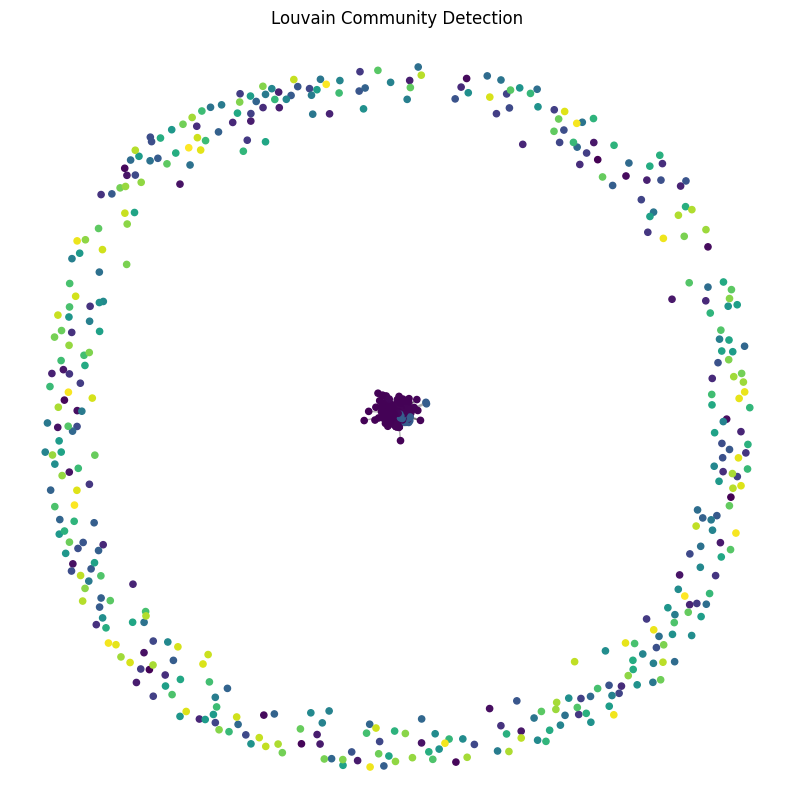

In [30]:
# Step 2: Apply Louvain Community Detection

# import community as community_louvain  # python-louvain package
import matplotlib.cm as cm
import community.community_louvain as community_louvain


# # Compute the best partition using Louvain method
# partition = community_louvain.best_partition(G)

# # Assign community to each node in the graph
# nx.set_node_attributes(G, partition, 'community')
# df['community'] = df['id'].map(partition)

# # Plot graph colored by community
# pos = nx.spring_layout(G, seed=42)
# cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

# plt.figure(figsize=(10, 10))
# nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=20,
#                        cmap=cmap, node_color=list(partition.values()))
# nx.draw_networkx_edges(G, pos, alpha=0.3)
# plt.title("Louvain Community Detection")
# plt.axis('off')
# plt.show()

import matplotlib.cm as cm

# Louvain partitioning
partition = community_louvain.best_partition(G)

# Add partition data to graph and DataFrame
nx.set_node_attributes(G, partition, 'community')
df['community'] = df['id'].map(partition)

# Plotting
pos = nx.spring_layout(G, seed=42)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_color=list(partition.values()),
                       cmap=cmap, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Louvain Community Detection")
plt.axis('off')
plt.show()


In [31]:
#  Step 3: Concatenate text for each community

from collections import defaultdict

# Group bag_of_phrases by community
community_texts = defaultdict(list)
for i, row in df.iterrows():
    comm = row['community']
    community_texts[comm].append(row['bag_of_phrases'])

# Combine phrases per community
for comm in community_texts:
    community_texts[comm] = " ".join(community_texts[comm])

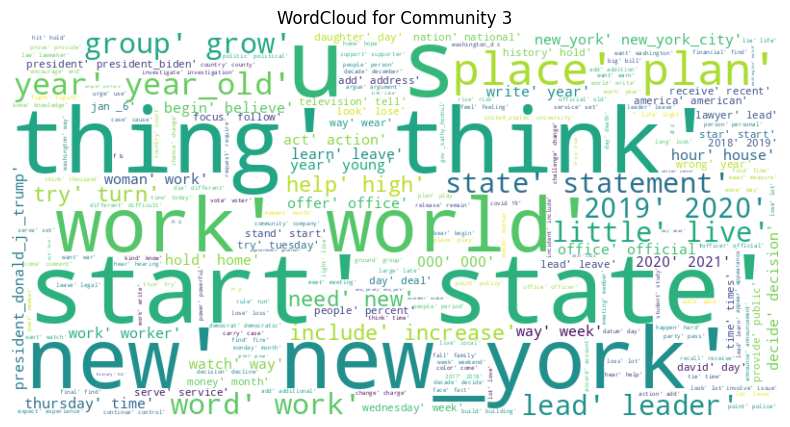

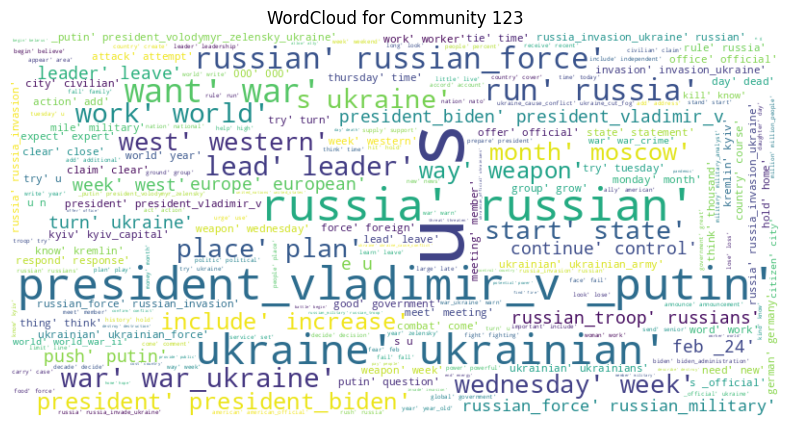

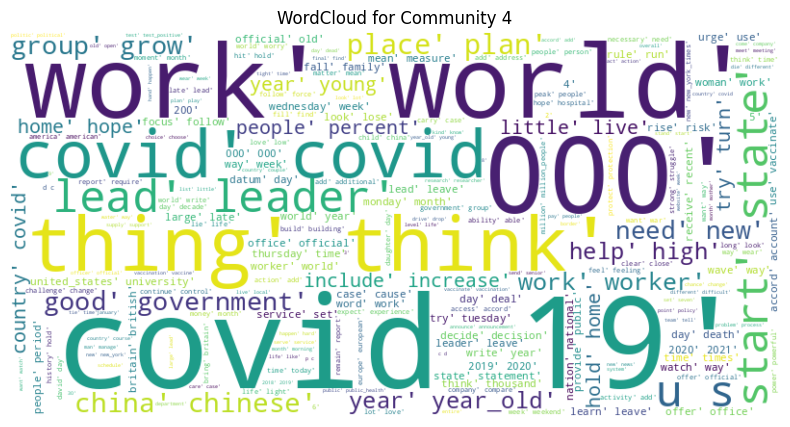

In [32]:
# Step 4: Generate WordClouds for top 3 communities

from wordcloud import WordCloud

# Sort communities by number of nodes
top_communities = df['community'].value_counts().head(3).index

for comm in top_communities:
    text = community_texts[comm]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud for Community {comm}")
    plt.axis('off')
    plt.show()

In [33]:
print("Task 6 completed")

Task 6 completed


## Task 7: Pearson Correlation between Retweet, Reply, and Like Counts


In [34]:
from scipy.stats import pearsonr
# Step 1: Compute Pearson correlation and p-values

# Define the pairs to analyze
metric_pairs = [
    ('retweet_count', 'like_count'),
    ('reply_count', 'like_count')
]

# Store results
correlation_results = []

for metric1, metric2 in metric_pairs:
    # Drop rows with missing values in the relevant columns
    subset = df[[metric1, metric2]].dropna()

    # Compute Pearson correlation and p-value
    corr, p_val = pearsonr(subset[metric1], subset[metric2])

    # Display result
    print(f"Correlation between {metric1} and {metric2}:")
    print(f"  Pearson Correlation: {corr:.4f}")
    print(f"  p-value: {p_val:.4e}")
    print()

    correlation_results.append({
        'Metric 1': metric1,
        'Metric 2': metric2,
        'Pearson Correlation': corr,
        'p-value': p_val
    })

Correlation between retweet_count and like_count:
  Pearson Correlation: 0.9332
  p-value: 0.0000e+00

Correlation between reply_count and like_count:
  Pearson Correlation: 0.4129
  p-value: 1.7101e-164



In [35]:
# Step 2: Save results to CSV

corr_df = pd.DataFrame(correlation_results)
corr_df.to_csv("pearson_correlation_task7.csv", index=False)
print("Correlation results saved to pearson_correlation_task7.csv")

Correlation results saved to pearson_correlation_task7.csv


In [36]:
print("Task 7 completed")

Task 7 completed


## Task 8: Pearson Correlation Between Token Count and Engagement

In [37]:
# Step 1: Count number of tokens in bag_of_phrases

# Create a new column: number of tokens in bag_of_phrases
df['num_tokens'] = df['bag_of_phrases'].apply(lambda x: len(str(x).split()))

In [38]:
# Step 2: Compute Pearson correlation and p-values

from scipy.stats import pearsonr

# Define metric pairs
token_metric_pairs = [
    ('retweet_count', 'num_tokens'),
    ('reply_count', 'num_tokens'),
    ('like_count', 'num_tokens')
]

# Store results
token_corr_results = []

for metric, token_col in token_metric_pairs:
    subset = df[[metric, token_col]].dropna()

    corr, p_val = pearsonr(subset[metric], subset[token_col])

    print(f"Correlation between {metric} and number of tokens:")
    print(f"  Pearson Correlation: {corr:.4f}")
    print(f"  p-value: {p_val:.4e}")
    print()

    token_corr_results.append({
        'Metric': metric,
        'Token Column': token_col,
        'Pearson Correlation': corr,
        'p-value': p_val
    })

Correlation between retweet_count and number of tokens:
  Pearson Correlation: -0.0464
  p-value: 3.3461e-03

Correlation between reply_count and number of tokens:
  Pearson Correlation: -0.0345
  p-value: 2.8971e-02

Correlation between like_count and number of tokens:
  Pearson Correlation: -0.0604
  p-value: 1.3172e-04



In [39]:
# Step 3: Save results to CSV (optional)

token_corr_df = pd.DataFrame(token_corr_results)
token_corr_df.to_csv("token_correlation_task8.csv", index=False)
print("Results saved to token_correlation_task8.csv")

Results saved to token_correlation_task8.csv


In [40]:
print("Task 8 completed")

Task 8 completed


## Task 9: Erdos Number Based on Degree Centrality

In [41]:
# Step 1: Identify node with highest degree

# Get degree for each node
degree_dict = dict(G.degree())

# Find node with highest degree (Erdos node)
erdos_node = max(degree_dict, key=degree_dict.get)
print(f"Erdos-like node (highest degree): {erdos_node} with degree {degree_dict[erdos_node]}")

Erdos-like node (highest degree): 1489623725351878671 with degree 2642


In [42]:
#  Step 2: Compute Erdos numbers (shortest path lengths)

# Compute Erdos number as shortest path lengths from Erdos node
erdos_numbers = nx.single_source_shortest_path_length(G, erdos_node)

# Convert to DataFrame for saving
erdos_df = pd.DataFrame(list(erdos_numbers.items()), columns=["Node", "Erdos_Number"])
erdos_df.to_csv("erdos_numbers_task9.csv", index=False)
print("Erdos numbers saved to erdos_numbers_task9.csv")

Erdos numbers saved to erdos_numbers_task9.csv


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


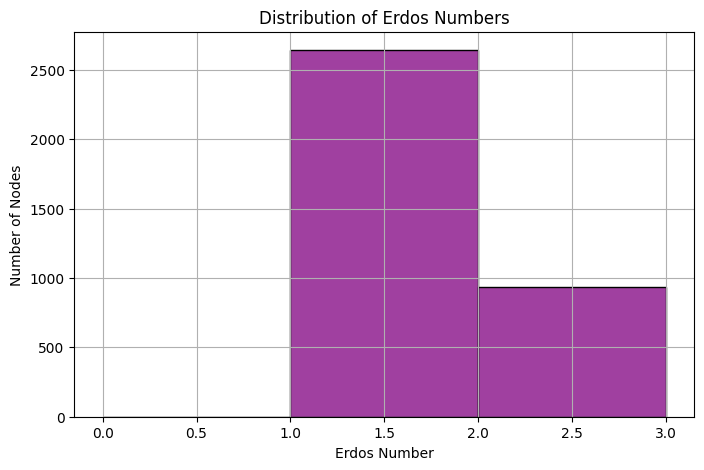

In [43]:
# Step 3: Plot distribution of Erdos numbers

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(erdos_df["Erdos_Number"], bins=range(erdos_df["Erdos_Number"].max()+1), kde=False, color="purple")
plt.title("Distribution of Erdos Numbers")
plt.xlabel("Erdos Number")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()

In [44]:
print("Task 9-1 completed")

Task 9-1 completed


## Task 9: Erdos Node = Highest (Degree + Closeness) Mean

In [45]:
# Recalculate if needed
deg_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Compute the average of degree + closeness centrality
centrality_combo_1 = {node: (deg_centrality[node] + closeness_centrality[node]) / 2 for node in G.nodes()}
erdos_node_1 = max(centrality_combo_1, key=centrality_combo_1.get)
print(f"Erdos Node 1 (Deg + Closeness): {erdos_node_1}")

# Calculate Erdos numbers
erdos_dist_1 = nx.single_source_shortest_path_length(G, erdos_node_1)
df_erdos_1 = pd.DataFrame(erdos_dist_1.items(), columns=["Node", "Erdos_Number"])
df_erdos_1.to_csv("erdos_deg_closeness.csv", index=False)


Erdos Node 1 (Deg + Closeness): 1489623725351878671


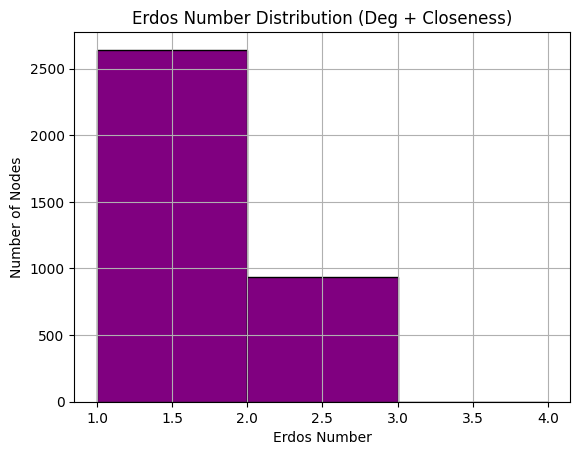

In [46]:
# Plot distribution
plt.hist(df_erdos_1["Erdos_Number"], bins=range(1, df_erdos_1["Erdos_Number"].max() + 2), color="purple", edgecolor="black")
plt.title("Erdos Number Distribution (Deg + Closeness)")
plt.xlabel("Erdos Number")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()

In [47]:
print("Task 9-2 completed")

Task 9-2 completed


## Task 10: Erdos Node = Highest (Degree + Betweenness) Mean

In [48]:
betweenness_centrality = nx.betweenness_centrality(G)

centrality_combo_2 = {node: (deg_centrality[node] + betweenness_centrality[node]) / 2 for node in G.nodes()}
erdos_node_2 = max(centrality_combo_2, key=centrality_combo_2.get)
print(f"Erdos Node 2 (Deg + Betweenness): {erdos_node_2}")

erdos_dist_2 = nx.single_source_shortest_path_length(G, erdos_node_2)
df_erdos_2 = pd.DataFrame(erdos_dist_2.items(), columns=["Node", "Erdos_Number"])
df_erdos_2.to_csv("erdos_deg_betweenness.csv", index=False)


Erdos Node 2 (Deg + Betweenness): 1489623725351878671


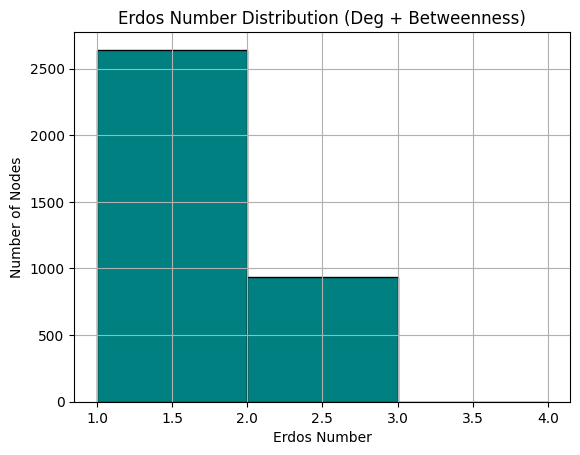

In [49]:
# Plot distribution
plt.hist(df_erdos_2["Erdos_Number"], bins=range(1, df_erdos_2["Erdos_Number"].max() + 2), color="teal", edgecolor="black")
plt.title("Erdos Number Distribution (Deg + Betweenness)")
plt.xlabel("Erdos Number")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()


In [50]:
print("Task 10 completed")

Task 10 completed


## Task 11: Erdos Node = Highest Degree Centrality

In [51]:
erdos_node_3 = max(deg_centrality, key=deg_centrality.get)
print(f"Erdos Node 3 (Highest Degree Centrality): {erdos_node_3}")

erdos_dist_3 = nx.single_source_shortest_path_length(G, erdos_node_3)
df_erdos_3 = pd.DataFrame(erdos_dist_3.items(), columns=["Node", "Erdos_Number"])
df_erdos_3.to_csv("erdos_highest_degree.csv", index=False)


Erdos Node 3 (Highest Degree Centrality): 1489623725351878671


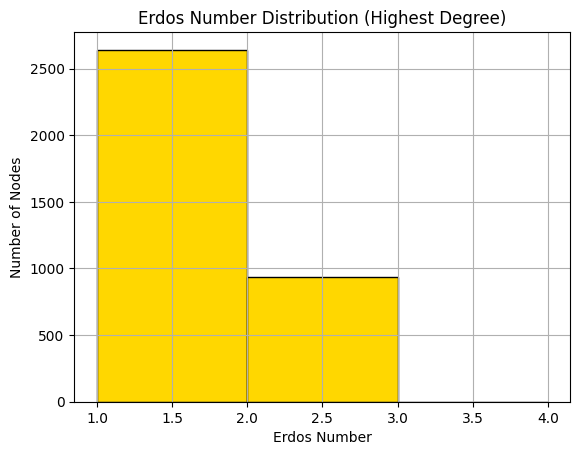

In [52]:
# Plot distribution
plt.hist(df_erdos_3["Erdos_Number"], bins=range(1, df_erdos_3["Erdos_Number"].max() + 2), color="gold", edgecolor="black")
plt.title("Erdos Number Distribution (Highest Degree)")
plt.xlabel("Erdos Number")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()


In [53]:
print("Task 11 completed")

Task 11 completed


## Task 12: Comparison Table of Erdos Simulations

In [54]:
# Function to summarize each result
def summarize_erdos(df):
    return {
        "Nodes Covered": len(df),
        "Max Erdos Number": df["Erdos_Number"].max(),
        "Std Dev": df["Erdos_Number"].std()
    }

summary_1 = summarize_erdos(df_erdos_1)
summary_2 = summarize_erdos(df_erdos_2)
summary_3 = summarize_erdos(df_erdos_3)

comparison_df = pd.DataFrame([
    {"Strategy": "Deg + Closeness", **summary_1},
    {"Strategy": "Deg + Betweenness", **summary_2},
    {"Strategy": "Highest Degree", **summary_3}
])

print(comparison_df)
comparison_df.to_csv("erdos_strategy_comparison.csv", index=False)


            Strategy  Nodes Covered  Max Erdos Number   Std Dev
0    Deg + Closeness           3578                 3  0.440685
1  Deg + Betweenness           3578                 3  0.440685
2     Highest Degree           3578                 3  0.440685


In [55]:
print("Task 12 completed")
print("ALL DONE")

Task 12 completed
ALL DONE
